## Programación Cuadrática

Solución a los ejercicios propuestos en el cuaderno 3.1

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

### Datos

In [2]:
import pickle

In [3]:
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

In [4]:
close_dict = {tk: df.close for tk,df in stock_data.items()}
stock_close = pd.DataFrame(close_dict)

In [5]:
data_close = stock_close.loc['2019-01-02':'2019-12-31'].dropna(axis=1)

Para simplificar el ejercicio trabajaremos con un universo reducido
de 10 activos del IBEX.

In [6]:
data_close = data_close[['ACS','TEF','ITX','GRF','AMS','ENG','MAP','REP','AENA','VIS']]
data_close.head()

,ACS,TEF,ITX,GRF,AMS,ENG,MAP,REP,AENA,VIS
2019-01-02,29.254370,6.995052,21.723158,22.446920,59.910340,21.491329,2.062509,11.817150,131.210901,44.423518
2019-01-03,29.324778,7.111227,21.413242,22.525924,56.614491,21.759635,2.072394,11.833753,131.258788,44.290456
2019-01-04,29.764826,7.203789,22.168662,23.276459,58.564697,21.804353,2.130810,12.116003,134.563004,45.088825
2019-01-07,29.861636,7.268960,22.342990,23.256708,59.110755,21.786465,2.129911,12.016386,133.270050,45.240895
2019-01-08,30.169670,7.257626,22.827233,23.602349,60.612414,22.090546,2.127215,12.028838,134.084132,46.134308


___

Calculamos la media de los retornos logaritmicos y la matriz de covarianzas de los
retornos

In [7]:
returns = np.log(data_close).diff().dropna()
cov_returns = returns.cov()
mean_returns = returns.mean()

In [8]:
mean_returns

ACS     0.000481
TEF    -0.000458
ITX     0.001457
GRF     0.001325
AMS     0.000738
ENG     0.000054
MAP     0.000334
REP     0.000435
AENA    0.001031
VIS     0.000166
dtype: float64

In [9]:
cov_returns

,ACS,TEF,ITX,GRF,AMS,ENG,MAP,REP,AENA,VIS
ACS,0.000183,0.000066,0.000063,0.000042,0.000078,0.000024,0.000070,0.000081,0.000054,0.000084
TEF,0.000066,0.000118,0.000048,0.000011,0.000049,0.000027,0.000068,0.000057,0.000043,0.000035
ITX,0.000063,0.000048,0.000177,0.000054,0.000078,0.000029,0.000044,0.000061,0.000052,0.000064
GRF,0.000042,0.000011,0.000054,0.000178,0.000072,0.000016,0.000022,0.000022,0.000037,0.000047
AMS,0.000078,0.000049,0.000078,0.000072,0.000200,0.000037,0.000048,0.000065,0.000048,0.000067
ENG,0.000024,0.000027,0.000029,0.000016,0.000037,0.000207,0.000011,0.000028,0.000027,0.000033
MAP,0.000070,0.000068,0.000044,0.000022,0.000048,0.000011,0.000132,0.000060,0.000046,0.000040
REP,0.000081,0.000057,0.000061,0.000022,0.000065,0.000028,0.000060,0.000149,0.000033,0.000046
AENA,0.000054,0.000043,0.000052,0.000037,0.000048,0.000027,0.000046,0.000033,0.000105,0.000044
VIS,0.000084,0.000035,0.000064,0.000047,0.000067,0.000033,0.000040,0.000046,0.000044,0.000301


___

#### Espacio de posibles carteras
Simulamos primero un conjunto aleatorio de pesos para visualizar el espacio
de posibles carteras 

In [15]:
n = mean_returns.shape[0]
list_ret_p = []
list_std_p = []
list_w = []
for _ in range(10000):
    w = np.random.rand(n)           # pesos aleatorios   
    w = w / np.sum(w)               # Escalamos para que sumen 1
    ret_p = mean_returns.dot(w)
    std_p = np.sqrt(w @ cov_returns.values @ w)  
    list_ret_p.append(ret_p)
    list_std_p.append(std_p)
    list_w.append(w)

___

### Ejercicio 1

Modificamos la función de la frontera eficiente para aceptar un parámetro de posicion máxima

In [17]:
def efficient_frontier(returns, n_samples=50, gamma_low=-1, gamma_high=10,
                       max_w=1.0, min_w=0.0):
    """
    construye un conjunto de problemas de programación cuádrática
    para inferir la frontera eficiente de Markovitz. 
    En cada problema el parámetro gamma se cambia para aumentar
    la penalización del riesgo en la función de maximización.
    """
    sigma = returns.cov().values
    mu = np.mean(returns, axis=0).values  
    n = sigma.shape[0]        
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, sigma)
    
    prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
                      [cp.sum(w) == 1,  
                       w >= min_w,
                       w <= max_w]) 
    # Equivalente 
    #prob = cp.Problem(cp.Minimize(risk - gamma*ret), 
    #                  [cp.sum(w) == 1,  w >= 0])   
    risk_data = np.zeros(n_samples)
    ret_data = np.zeros(n_samples)
    gamma_vals = np.logspace(gamma_low, gamma_high, num=n_samples)
    
    portfolio_weights = []    
    for i in range(n_samples):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = np.sqrt(risk.value)
        ret_data[i] = ret.value
        portfolio_weights.append(w.value)   
    return ret_data, risk_data, gamma_vals, portfolio_weights



In [22]:
ret, risk, _, port = efficient_frontier(returns)
ret1, risk1, _, port1 = efficient_frontier(returns, max_w=0.20)
ret2, risk2, _, port2 = efficient_frontier(returns, max_w=0.15)

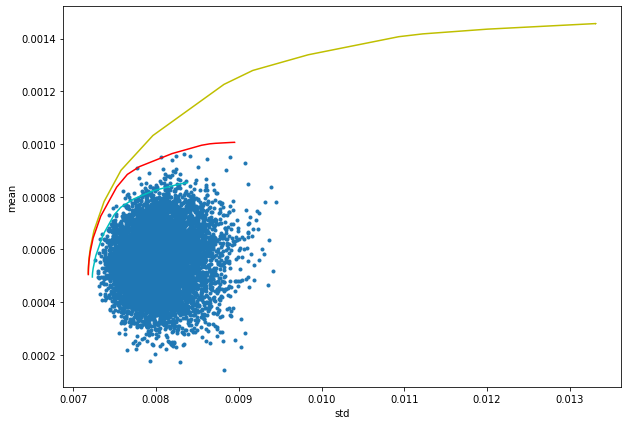

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(list_std_p, list_ret_p, '.')
ax.plot(risk, ret, 'y')
ax.plot(risk1, ret1, 'r')
ax.plot(risk2, ret2, 'c')

#ax.plot(optimal_risk, optimal_ret, '*', markersize=15)
_ = ax.set_xlabel('std')
_ = ax.set_ylabel('mean')


___

### Ejercicio 2

In [16]:
Sigma = cov_returns.values
mu = mean_returns.values

In [26]:
returns

,ACS,TEF,ITX,GRF,AMS,ENG,MAP,REP,AENA,VIS
2019-01-03,0.002404,0.016472,-0.014369,0.003513,-0.056584,0.012407,0.004782,0.001404,0.000365,-0.003000
2019-01-04,0.014895,0.012932,0.034670,0.032776,0.033867,0.002053,0.027797,0.023571,0.024862,0.017865
2019-01-07,0.003247,0.009006,0.007833,-0.000849,0.009281,-0.000821,-0.000422,-0.008256,-0.009655,0.003367
2019-01-08,0.010263,-0.001560,0.021442,0.014753,0.025087,0.013861,-0.001267,0.001036,0.006090,0.019555
2019-01-09,0.008713,-0.020644,0.011390,0.013713,0.004494,-0.004463,-0.004658,0.014049,-0.010772,0.004522
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.006053,-0.012166,0.007291,0.011324,0.007726,0.007342,-0.002061,0.004604,0.007237,-0.017441
2019-12-24,0.016529,-0.006529,0.003468,0.000313,0.012836,0.006861,-0.009534,0.000353,0.002880,-0.020670
2019-12-27,-0.005385,0.000312,0.011890,0.003122,-0.000814,-0.000855,0.007882,0.003174,0.006879,0.010389
2019-12-30,0.000000,-0.014764,-0.012520,-0.011916,-0.009825,-0.007729,-0.011220,-0.005296,-0.011491,-0.007885


In [33]:
tickers = returns.columns

In [37]:
mid_cap_tickers = ['ACS','MAP','VIS','ENG']

In [38]:
idxmid = [tickers.get_loc(t) for t in mid_cap_tickers]

In [39]:
idxmid


[0, 6, 9, 5]

In [45]:
w = cp.Variable(n)

port_risk = cp.quad_form(w, Sigma)
port_ret = mu @ w
constraints = [
    cp.sum(w) == 1, 
    w >= 0,
    w <= 0.2,
    cp.sum(w[idxmid]) <= 0.25
]

prob = cp.Problem(cp.Minimize(port_risk), 
                  constraints) 
prob.solve()

5.184828437246974e-05

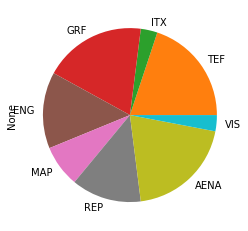

In [46]:
cartera = pd.Series(w.value, index=returns.columns).round(3)
cartera.plot.pie()

In [47]:
cartera

ACS     0.000
TEF     0.199
ITX     0.031
GRF     0.190
AMS    -0.000
ENG     0.142
MAP     0.078
REP     0.130
AENA    0.200
VIS     0.030
dtype: float64

In [48]:
cartera.iloc[idxmid]

ACS    0.000
MAP    0.078
VIS    0.030
ENG    0.142
dtype: float64

In [49]:
port_risk.value, port_ret.value

(5.1848284372469734e-05, 0.0005076703301538991)